Make model

In [2]:
import torch
import numpy as np
from torch import nn

from src.algo.language.lm import GRUEncoder, OneHotEncoder
from src.algo.nn_modules.mlp import MLPNetwork
    

class LanguageEncoder(nn.Module):

    """ 
    Class to manage and train the language modules: the Language Encoder, the 
    Observation Encoder and the Decoder. 
    """

    def __init__(self, input_dim, context_dim, hidden_dim, embed_dim, policy_layer_N, 
                 lr, vocab, max_message_len, device="cuda:0"):
        super(LanguageEncoder, self).__init__()
        self.device = device

        self.word_encoder = OneHotEncoder(vocab, max_message_len)

        self.lang_encoder = GRUEncoder(
            context_dim, 
            hidden_dim, 
            embed_dim, 
            self.word_encoder,
            device=device)

        self.obs_encoder = MLPNetwork(
            input_dim, context_dim, hidden_dim, policy_layer_N)

        self.clip_loss = nn.CrossEntropyLoss()
        # self.captioning_loss = nn.NLLLoss()

        self.optim = torch.optim.Adam( 
            self.parameters(),
            # list(self.lang_encoder.parameters()) +
            # list(self.obs_encoder.parameters()) +
            # list(self.decoder.parameters()),
            lr=lr)

    def prep_rollout(self, device):
        self.device = device
        self.eval()
        self.to(self.device)
        self.lang_encoder.device = self.device

    def prep_training(self, device):
        self.device = device
        self.train()
        self.to(self.device)
        self.lang_encoder.device = self.device

    def encode_sentences(self, sentence_batch):
        """ 
        Encode a batch of sentences. 
        :param sentence_batch (list(list(int))): Batch of enoded sentences.

        :return context_batch (torch.Tensor): Batch of context vectors, 
            dim=(batch_size, context_dim).
        """
        context_batch = self.lang_encoder(sentence_batch).squeeze(0)
        return context_batch

    def get_save_dict(self):
        save_dict = {
            "lang_encoder": self.lang_encoder.state_dict(),
            "obs_encoder": self.obs_encoder.state_dict()}
        return save_dict

    def load_params(self, save_dict):
        self.lang_encoder.load_state_dict(save_dict["lang_encoder"])
        self.obs_encoder.load_state_dict(save_dict["obs_encoder"])

In [4]:
obs_dim = 77
context_dim = 2
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

Transform sentences to ids

In [2]:
import pandas as pd
import random
import json

def load_data(path):
    df = pd.read_csv(path, index_col=0)
    df = df.fillna('')

    # Drop majority of rows with empty message
    empty_ids = df.index[df["lang"] == ''].tolist()
    if len(empty_ids) > len(df) * 0.1:
        drop_ids = random.sample(empty_ids, int(len(empty_ids) - len(df) * 0.1))
        df = df.drop(drop_ids)

    # Prepare data
    df["lang"] = df["lang"].apply(lambda x: x.split(" "))
    df["obs"] = df["obs"].apply(json.loads)

    obs_dim = len(df.iloc[0]["obs"])
    max_len = max(df["lang"].apply(len))

    print(f"Obs dim = {obs_dim}, Max message length = {max_len}.")

    return df, obs_dim, max_len

def prep_data(df, ll):
    # Prepare data
    df["lang"] = df["lang"].apply(lambda x: x.split(" "))
    df["obs"] = df["obs"].apply(json.loads)

    # Encode words to token ids
    df["lang"] = ll.word_encoder.encode_batch(list(df["lang"]))

    return df

In [13]:
df = load_n_prep_data("../../results/data/lamarl_data/PPrgb_12.csv", ll)
df

,obs,lang
1,"[0.5454545454545454, 0.18181818181818182, 0.0,...","[2, 3, 1]"
5,"[0.45454545454545453, 0.18181818181818182, 0.0...","[2, 3, 1]"
9,"[0.36363636363636365, 0.18181818181818182, 0.0...","[2, 3, 1]"
13,"[0.36363636363636365, 0.18181818181818182, 0.0...","[2, 3, 1]"
17,"[0.36363636363636365, 0.18181818181818182, 0.0...","[2, 3, 1]"
...,...,...
3999965,"[0.18181818181818182, 0.9090909090909091, 0.0,...",[1]
3999968,"[0.9090909090909091, 0.8181818181818182, 1.0, ...","[2, 3, 1]"
3999988,"[1.0, 0.9090909090909091, 1.0, 0.0, 0.0, 0.0, ...","[2, 5, 1]"
3999992,"[1.0, 0.8181818181818182, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 6, 1]"


Train

In [4]:
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np 
%matplotlib inline

def clip(ll, enc_obs, enc_lang, temp, device):
    # Compute similarity
    norm_enc_obs = enc_obs / (enc_obs.norm(
        dim=1, keepdim=True))
    norm_enc_lang = enc_lang / enc_lang.norm(
        dim=1, keepdim=True)
    sim = norm_enc_obs @ norm_enc_lang.t() * temp
    mean_sim = sim.diag().mean()

    # Compute CLIP loss
    labels = torch.arange(enc_obs.shape[0]).to(device)
    loss_o = ll.clip_loss(sim, labels)
    loss_l = ll.clip_loss(sim.t(), labels)
    clip_loss = (loss_o + loss_l) / 2

    return clip_loss, mean_sim.item()

def train_lang_encoder(data, ll, n_epochs=5000, batch_size=512, temp=1.0, eval_every=500,
                       device="cuda:0", seed=0):
    # rs = np.random.RandomState(seed)

    train_data = data.iloc[:int(len(data) * 0.9)]
    eval_data = data.iloc[int(len(data) * 0.9):]

    train_losses = []
    eval_losses = []
    eval_sims = []

    ll.prep_training(device)

    for e_i in trange(n_epochs):
        ll.optim.zero_grad()
        sample = train_data.sample(n=batch_size)
        
        obs_batch = torch.Tensor(np.array(list(sample["obs"]))).to(device)
        lang_batch = list(sample["lang"])
    
        enc_obs = ll.obs_encoder(obs_batch)
        enc_lang = ll.encode_sentences(lang_batch)
        # print(enc_obs)
        # print(enc_lang)
        # return 0, 0, 0

        clip_loss, mean_sim = clip(ll, enc_obs, enc_lang, temp, device)
        train_losses.append(clip_loss.item())

        clip_loss.backward()
        ll.optim.step()

        if (e_i + 1) % eval_every == 0:
            with torch.no_grad():
                sample = eval_data.sample(n=batch_size) #, random_state=rs)

                obs_batch = torch.Tensor(np.array(list(sample["obs"]))).to(device)
                lang_batch = list(sample["lang"])
            
                enc_obs = ll.obs_encoder(obs_batch)
                enc_lang = ll.encode_sentences(lang_batch)

                clip_loss, mean_sim = clip(ll, enc_obs, enc_lang, temp, device)
                eval_losses.append(clip_loss.item())
                eval_sims.append(mean_sim)

    return train_losses, eval_losses, eval_sims

def plot_curves(train_losses, eval_losses, eval_sims, eval_every=500):
    plt.plot(train_losses, label="train loss")
    plt.plot(range(eval_every, len(train_losses) + 1, eval_every), eval_losses, label="eval loss")
    plt.plot(range(eval_every, len(train_losses) + 1, eval_every), eval_sims, label="mean sim")
    plt.legend()
    

  0%|          | 0/10000 [00:00<?, ?it/s]/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10000/10000 [03:36<00:00, 46.15it/s]


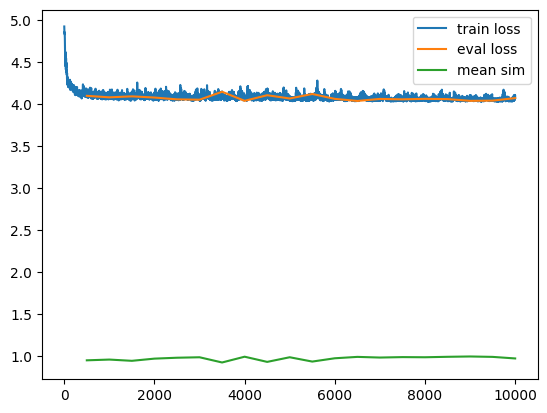

In [8]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

n_ep = 10000
eval_every = 500
batch_size=128

train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

plot_curves(train_losses, eval_losses, eval_sims, eval_every)

In [29]:
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/PPrgb_15_langground.pt")

PP_12

  0%|          | 0/10000 [00:00<?, ?it/s]/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10000/10000 [04:11<00:00, 39.80it/s]


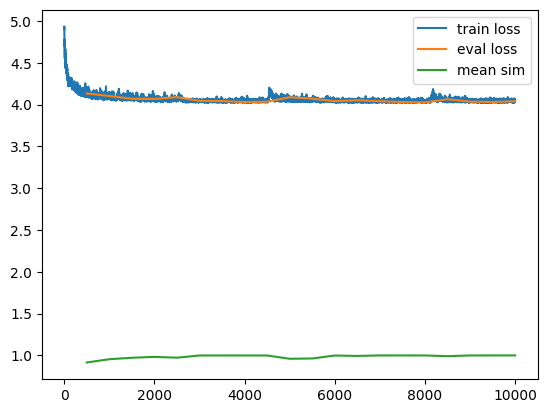

In [15]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

# Make model
ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/PPrgb_12.csv", ll)

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/PPrgb_12_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

PP_18

Prepare data...
Training...


100%|██████████| 10000/10000 [03:48<00:00, 43.86it/s]


Saving model...
Plot...


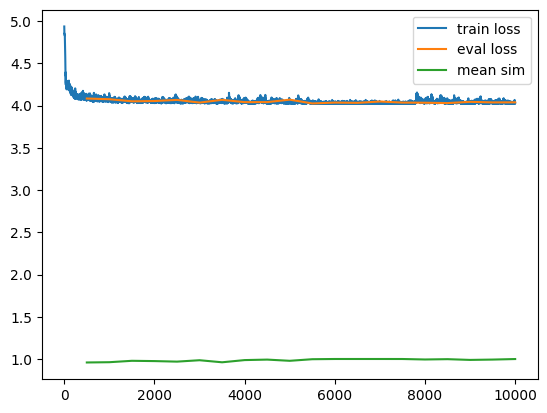

In [16]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

# Make model
ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/PPrgb_18.csv", ll)
df.head()

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/PPrgb_18_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

F_18

Prepare data...
Training...


100%|██████████| 10000/10000 [07:12<00:00, 23.10it/s]


Saving model...
Plot...


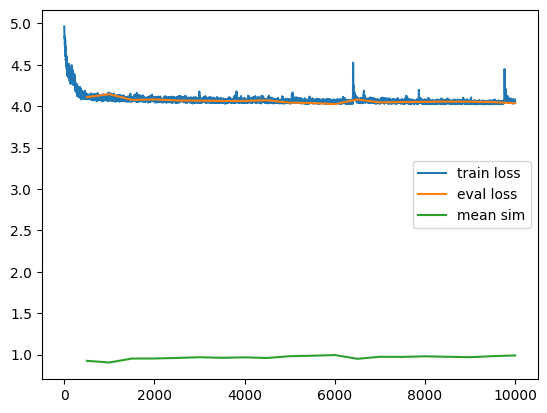

In [17]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

# Make model
ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/Frgb_18.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/Frgb_18_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

#### Coordinated Placement

Prepare data...
                                obs lang
130  [0.6, 0.4, 0.0, 0.0, 0.0, 0.0]  [1]
138  [0.6, 0.6, 0.0, 0.0, 0.0, 0.0]  [1]
211  [0.4, 0.6, 0.0, 0.0, 0.0, 0.0]  [1]
359  [0.4, 0.4, 0.0, 0.0, 0.0, 0.0]  [1]
406  [0.6, 0.4, 0.0, 0.0, 0.0, 0.0]  [1]
Training...


100%|██████████| 10000/10000 [04:02<00:00, 41.15it/s]


Saving model...
Plot...


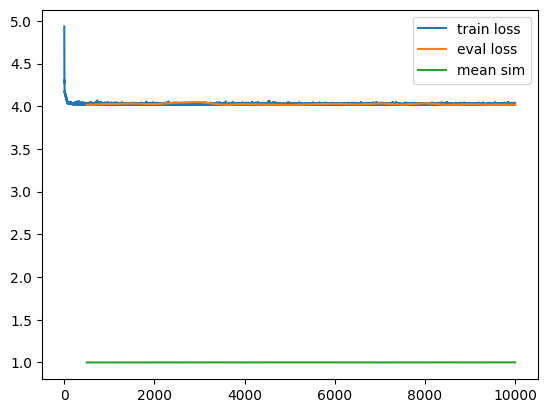

In [5]:
obs_dim = 6
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Red", "Green", "Blue", "Yellow", "Cyan", "Purple", 
         "Center", "North", "South", "East", "West"]
max_mess_len = 6

ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/CPrgb.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/CPrgb2a_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

#### MPE PredPrey shape

Prepare data...
                                                  obs          lang
3   [-0.3978937954675634, 0.6037069236883319, 0.0,...  [2, 3, 6, 1]
10  [0.6647520869790569, -0.46581742637504625, 1.0...     [2, 5, 1]
25  [-0.43972410571943776, 0.8303000586581575, 0.0...           [1]
27  [0.7176012056710457, -0.6751510004988324, 0.0,...  [2, 4, 5, 1]
39  [-0.5801896936144422, -0.3628454873403809, 0.0...  [2, 4, 6, 1]
Training...


100%|██████████| 10000/10000 [03:26<00:00, 48.48it/s]


Saving model...
Plot...


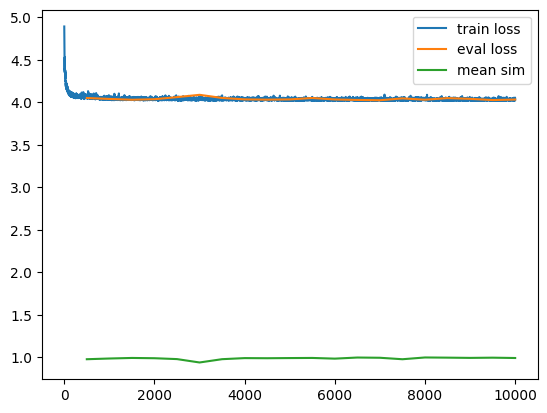

In [9]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch
import numpy as np
from torch import nn

obs_dim = 14
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "North", "South", "East", "West", "Center"]
max_mess_len = 3

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/MPEPPshap.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/MPEPPshap_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

MPE simple reference

Prepare data...
                                                 obs          lang
0  [-0.546905157736554, 0.1888402887822651, 0.0, ...  [8, 2, 4, 1]
1  [-0.14338263014061048, 0.52828137310774, 0.0, ...     [9, 4, 1]
2  [0.3473246945042501, 0.711111465136617, 0.0, 0...     [9, 2, 1]
3  [-0.8438883202843137, -0.29500029288046825, 0....  [8, 3, 5, 1]
4  [0.837783303678836, -0.07007698848430999, 0.0,...     [7, 5, 1]
Training...


  0%|          | 0/10000 [00:00<?, ?it/s]/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10000/10000 [16:24<00:00, 10.15it/s]


Saving model...
Plot...


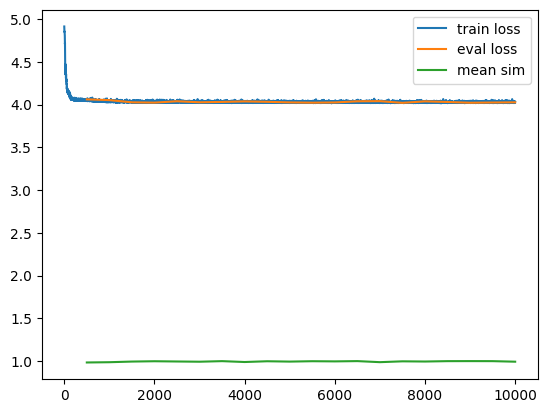

In [ ]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch
import numpy as np

obs_dim = 27
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["North", "South", "East", "West", "Center", "Red", "Green", "Blue"]
max_mess_len = 3

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/MPESimpRef.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/MPESimpRef_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

### Foraging Hostile

18

Prepare data...
                                                 obs                     lang
2  [0.5294117647058824, 0.47058823529411764, 0.0,...                      [1]
3  [0.5294117647058824, 0.5294117647058824, 0.0, ...                      [1]
4  [0.47058823529411764, 0.47058823529411764, 0.0...            [10, 8, 3, 1]
5  [0.47058823529411764, 0.5294117647058824, 0.0,...  [10, 8, 3, 10, 8, 3, 1]
7  [0.5294117647058824, 0.5294117647058824, 1.0, ...            [10, 8, 3, 1]
Training...


100%|██████████| 10000/10000 [08:38<00:00, 19.27it/s]

Saving model...
Plot...


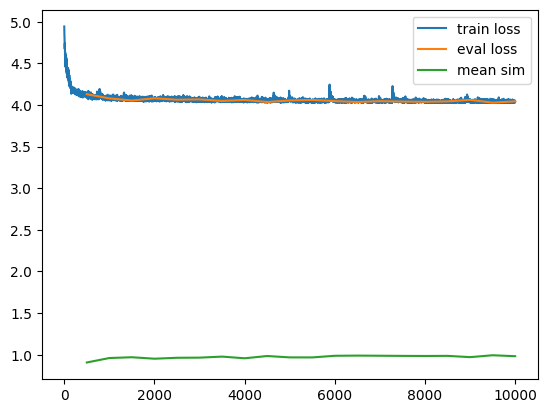

In [8]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch
import numpy as np

obs_dim = 78
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = [
            "Prey", "Center", "North", "South", "East", "West",
            "Gem", "Yellow", "Green", "Purple", "Danger"]
max_mess_len = 3

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/FH_18.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/FH18_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

15

Prepare data...
                                                 obs           lang
0  [0.42857142857142855, 0.42857142857142855, 0.0...            [1]
2  [0.5, 0.42857142857142855, 0.0, 0.0, 0.0, 0.0,...  [10, 8, 3, 1]
4  [0.42857142857142855, 0.42857142857142855, 0.0...  [10, 8, 3, 1]
5  [0.42857142857142855, 0.5, 0.0, 0.0, 0.0, 0.0,...  [10, 8, 3, 1]
7  [0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            [1]
Training...


100%|██████████| 10000/10000 [12:26<00:00, 13.39it/s]


Saving model...
Plot...


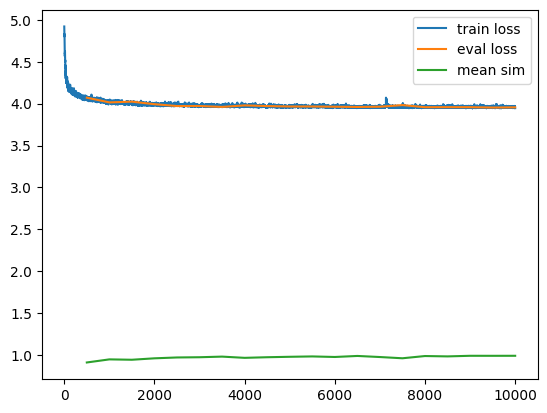

In [3]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch
import numpy as np

obs_dim = 78
context_dim = 8
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = [
            "Prey", "Center", "North", "South", "East", "West",
            "Gem", "Yellow", "Green", "Purple", "Danger"]
max_mess_len = 6

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)
ll.prep_training("cuda:0")

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/FH_15.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/FH15_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

### MPE Simple Hard Color Reference

Prepare data...
                                                 obs              lang
0  [-0.4546727185061965, -0.28532076742924795, 0....     [10, 7, 6, 1]
1  [0.23724878091226564, 0.28268197107716686, 0.0...  [11, 9, 2, 5, 1]
2  [-0.6453985839886807, -0.8833278563832387, 0.0...      [9, 2, 4, 1]
3  [-0.680088702468495, -0.02283318361665554, 0.0...     [11, 8, 3, 1]
4  [-0.6296575878278001, -0.2676881379165008, 0.0...         [8, 3, 1]
Training...


100%|██████████| 10000/10000 [07:33<00:00, 22.07it/s]


Saving model...
Plot...


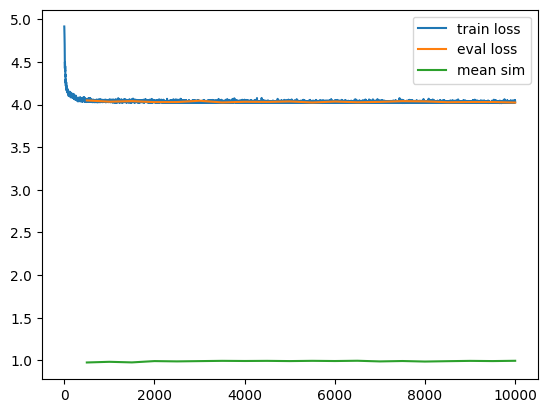

In [ ]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch


df, obs_dim, max_len = load_data("../../results/data/lamarl_data/MPEHardSimpRef.csv", ll)
print(df.head())

context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["North", "South", "East", "West", "Center", "Red", "Green", "Blue", "Light", "Dark"]

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = prep_data(df, ll)

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/MPEHardSimpRef_lg.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

## Display embedding clusters

In [29]:
import random
import math

def color_distance(c1, c2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(c1, c2)))

def generate_distinct_colors(n, threshold=0.3, max_attempts=1000):
    colors = []
    attempts = 0

    while len(colors) < n and attempts < max_attempts:
        candidate = (random.random(), random.random(), random.random())
        if all(color_distance(candidate, existing) >= threshold for existing in colors):
            colors.append(candidate)
        attempts += 1

    if len(colors) < n:
        raise ValueError("Could not generate enough distinct colors. Try lowering the threshold.")

    return colors

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

def generate_gradient_colors(n, cmap_name='hls'):
    # cmap = cm.get_cmap(cmap_name)
    cmap = sns.color_palette(cmap_name, n, as_cmap=True)
    colors = [cmap(i / (n - 1))[:3] for i in range(n)]  # Get RGB part only
    return colors

In [3]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch
import numpy as np

obs_dim = 78
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = [
            "Prey", "Center", "North", "South", "East", "West",
            "Gem", "Yellow", "Green", "Purple", "Danger"]
max_mess_len = 3

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)
ll.load_params(torch.load("../../results/data/lamarl_data/FH15_langground.pt"))

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/FH_15.csv", ll)
print(df.head())

Prepare data...
                                                 obs           lang
2  [0.5, 0.42857142857142855, 0.0, 0.0, 0.0, 0.0,...  [10, 8, 3, 1]
3  [0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            [1]
4  [0.42857142857142855, 0.42857142857142855, 0.0...  [10, 8, 3, 1]
5  [0.42857142857142855, 0.5, 0.0, 0.0, 0.0, 0.0,...  [10, 8, 3, 1]
7  [0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            [1]


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap
import seaborn as sns



ll.prep_rollout("cpu")

eval_data = df.iloc[-5000:]

# Remove rows with long messages
rids = []
for i, row in eval_data.iterrows():
    if len(row["lang"]) > 5:# or len(row["lang"]) <= 1 or 10 not in row["lang"]:# or 10 not in row["lang"]:
        rids.append(i)
display_data = eval_data.drop(rids)
display_data


,obs,lang
3993322,"[0.7857142857142857, 1.0, 0.0, 0.0, 0.0, 0.0, ...",[1]
3993323,"[0.5714285714285714, 0.5714285714285714, 0.0, ...","[10, 8, 3, 1]"
3993324,"[0.2857142857142857, 0.6428571428571429, 0.0, ...","[11, 8, 4, 1]"
3993325,"[0.35714285714285715, 0.2857142857142857, 0.0,...","[10, 8, 4, 1]"
3993326,"[0.9285714285714286, 0.35714285714285715, 0.0,...","[10, 8, 5, 1]"
...,...,...
3999990,"[0.8571428571428571, 0.7857142857142857, 0.0, ...","[10, 8, 5, 6, 1]"
3999995,"[0.21428571428571427, 0.6428571428571429, 0.0,...","[11, 8, 4, 1]"
3999996,"[0.8571428571428571, 0.5, 0.0, 0.0, 0.0, 0.0, ...","[10, 8, 5, 1]"
3999997,"[0.0, 0.35714285714285715, 0.0, 0.0, 0.0, 0.0,...","[10, 8, 4, 1]"


In [43]:
obs = torch.Tensor(np.array(list(display_data["obs"])))
lang = [' '.join(s) for s in ll.word_encoder.decode_batch(list(display_data["lang"]))]

enc_obs = ll.obs_encoder(obs).detach().numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(enc_obs)

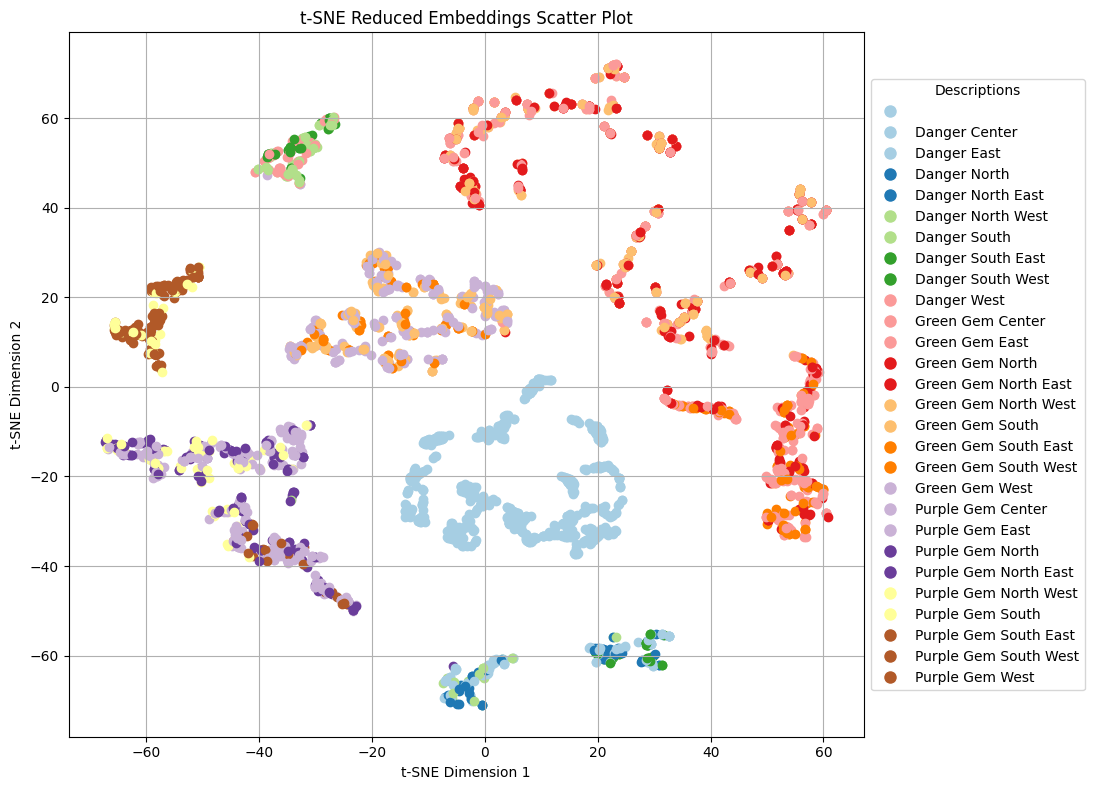

In [35]:
# Map descriptions to unique numeric labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(lang)

# Generate a color map
unique_labels = np.unique(labels)
# cmap = get_cmap('glasbey_bw', len(unique_labels))  # Use a larger colormap
# clrs = sns.color_palette('husl', n_colors=len(unique_labels))
# clrs = [(random.random(), random.random(), random.random()) for _ in range(len(unique_labels))]
# clrs = generate_distinct_colors(len(unique_labels), threshold=0.3)
clrs = generate_gradient_colors(len(unique_labels), cmap_name='Paired')
label_to_color = {label: clrs[idx] for idx, label in enumerate(unique_labels)}

# Scatter plot
plt.figure(figsize=(13, 8))
for idx, embedding in enumerate(embeddings_2d):
    label = labels[idx]
    plt.scatter(embedding[0], embedding[1], color=label_to_color[label], label=lang[idx])

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=10) 
           for label in unique_labels]
labels = label_encoder.inverse_transform(unique_labels)
plt.legend(handles, labels, title="Descriptions", loc="center left", bbox_to_anchor=(1, 0.5))

# Plot settings
plt.title("t-SNE Reduced Embeddings Scatter Plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# Show plot
plt.tight_layout(rect=[0, 0, 0.85, 1])

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(lang)
label_names = label_encoder.inverse_transform(np.unique(encoded_labels))

# Step 2: Prepare DataFrame for Plotly
df = pd.DataFrame(embeddings_2d, columns=["TSNE-1", "TSNE-2"])
df['Label'] = [label_encoder.inverse_transform([l])[0] for l in encoded_labels]

# Optional: Add color info using plotly's built-in color palettes or your own
# If you want to customize colors:
# from matplotlib.cm import get_cmap
# clrs = generate_gradient_colors(len(label_names), cmap_name='Paired')
# df['Color'] = [clrs[l] for l in encoded_labels]

# Step 3: Plot using Plotly
fig = px.scatter(
    df,
    x="TSNE-1",
    y="TSNE-2",
    color="Label",
    title="Interactive t-SNE Reduced Embeddings",
    labels={"Label": "Description"},
    hover_data={"Label": True},
)

# Step 4: Improve interactivity
fig.update_traces(marker=dict(size=6, opacity=0.8),
                  selector=dict(mode='markers'))
fig.update_layout(
    legend_title_text='Descriptions',
    legend=dict(itemsizing='constant'),
    width=1000,   # Set your desired width in pixels
    height=1000,   # Set your desired height in pixels
)

# Show the plot
fig.show()


In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Label Encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(lang)
label_names = label_encoder.inverse_transform(np.unique(encoded_labels))

# DataFrame creation
df = pd.DataFrame(embeddings_2d, columns=["TSNE-1", "TSNE-2"])
df['Label'] = [label_encoder.inverse_transform([l])[0] for l in encoded_labels]

# Initial color map
default_colors = px.colors.qualitative.Plotly
label_to_color = {label: default_colors[i % len(default_colors)] for i, label in enumerate(label_names)}

# ----- Dash App Setup -----
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("Interactive t-SNE with Color Picker"),
    html.Div([
        html.Div([
            html.Label(f"{label} Color:"),
            dcc.Dropdown(
                id={'type': 'color-picker', 'index': label},
                options=[{'label': c, 'value': c} for c in px.colors.qualitative.Alphabet],
                value=label_to_color[label],
                clearable=False
            )
        ], style={'margin': '10px'}) for label in label_names
    ], style={'display': 'flex', 'flexWrap': 'wrap'}),
    dcc.Graph(id='tsne-plot')
])

# ----- Callback to update plot based on selected colors -----
@app.callback(
    Output('tsne-plot', 'figure'),
    Input({'type': 'color-picker', 'index': dash.dependencies.ALL}, 'value')
)
def update_plot(colors):
    color_map = {label: color for label, color in zip(label_names, colors)}
    fig = px.scatter(
        df,
        x='TSNE-1',
        y='TSNE-2',
        color='Label',
        color_discrete_map=color_map,
        title='Interactive t-SNE Reduced Embeddings'
    )
    fig.update_layout(height=1000, width=1000)
    return fig

app.run(debug=True, use_reloader=False)


: 

In [ ]:
def plot_tsne(points, labels):
